In [1]:
# Initialize modules
import pandas as pd
import numpy as np
import censusdata
import matplotlib.pyplot as plt
from sodapy import Socrata
pd.set_option('display.precision', 2)

# Load Census Data from US Census Bureau
censustable = censusdata.download('acs5', 2019, censusdata.censusgeo([('state', '06'), \
                        ('county', '085'), ('tract', '*')]), ['B02001_001E', 'B02001_002E'])
censustable['Percent White Only'] = censustable['B02001_002E'].div(censustable['B02001_001E'])*100
censustable.head()
censusdata.export.exportcsv("census.csv", censustable)
census= pd.read_csv('census.csv')

# Load Covid-19 data from the County of Santa Clara
client = Socrata("data.sccgov.org", None)
results = client.get("can9-fquj", limit=2000)
# Convert to pandas DataFrame
covidcases = pd.DataFrame.from_records(results)
results2 = client.get("kbj4-a63r", limit=2000)
# Convert to pandas DataFrame
covidpos = pd.DataFrame.from_records(results2)

# Convert tract numbers
covidcases['tract'] = pd.to_numeric(covidcases['tract']) - 6085000000
covidpos['tract'] = pd.to_numeric(covidpos['tract']) - 6085000000

# Merge and tidy datasets
newone = pd.merge(left=covidpos, right=covidcases, left_on="tract", right_on="tract")
newone['caserate'] = pd.to_numeric(newone['case_rate']) / 1000
newerone = newone[{'tract', 'caserate', 'pos_rate'}]
newertwo = pd.merge(left=newerone, right=census, left_on="tract", right_on="tract")
newertwo = newertwo.drop(columns=['state', 'county', 'NAME', 'B02001_001E', 'B02001_002E'])

# Number rows
newertwo['row_num'] = np.arange(len(newertwo['tract']))

# Subroutine finished
print("Dataframe initialized.")

Dataframe initialized.


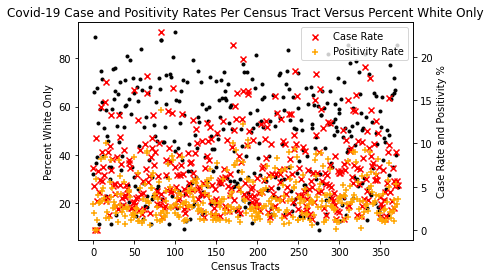

In [2]:
# Define plotdata() function
def plotdata(framename):
  fig,ax = plt.subplots()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['Percent White Only'])
  ax.scatter(x, y, marker='.', color='black', label="Percent White Only")
  plt.ylabel('Percent White Only')
  plt.xlabel('Census Tracts')
  plt.title('Covid-19 Case and Positivity Rates Per Census Tract Versus Percent White Only') 
  ax2=ax.twinx()
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['caserate'])
  ax2.scatter(x, y, marker='x', color='red', label="Case Rate")
  x = pd.to_numeric(framename['row_num'])
  y = pd.to_numeric(framename['pos_rate'])
  ax2.scatter(x, y, marker='+', color='orange', label="Positivity Rate")
  plt.ylabel('Case Rate and Positivity %')
  plt.legend()
 

# Clean dataframes
newertwo['pos_rate'].fillna(value=0, inplace=True)
newertwo['caserate'].fillna(value=0, inplace=True)

# Plot unsorted data
plotdata(newertwo)

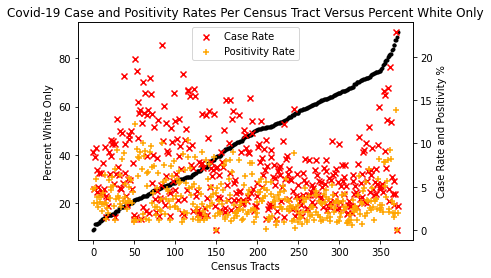

In [3]:
# Sort tracts by "Percent White Only"
newerthree = newertwo.sort_values(by=['Percent White Only'], axis=0, inplace=False)
newerthree['row_num'] = np.arange(len(newerthree['tract']))

# Plot sorted data
plotdata(newerthree)
